<a href="https://colab.research.google.com/github/jungeun919/Pytorch_study/blob/main/Pytorch_Tutorial/A_60_MINUTE_BLITZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# torch.autograd

### pytorch background

In [1]:
import torch, torchvision

model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [2]:
prediction = model(data)

In [3]:
loss = (prediction - labels).sum()
loss.backward()

In [4]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [5]:
optim.step()

### Differentiation in Autograd

In [6]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [7]:
Q = 3*a**3 - b**2

In [8]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

In [9]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


### DAG에서 제외

In [10]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does 'a' require gradients?: {a.requires_grad}")

b = x + z
print(f"Does 'b' require gradients?: {b.requires_grad}")

Does 'a' require gradients?: False
Does 'b' require gradients?: True


In [11]:
from torch import nn, optim

model = torchvision.models.resnet18(pretrained=True)

# 모든 매개변수를 고정
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 10)

optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)

# 신경망

### 네트워크 정의

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # kernel_size=(3, 3)
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 크기가 정사각형일 경우 하나의 숫자만 지정할 수 있음
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] # batch 차원을 제외한 모든 차원
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [14]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.1336, -0.0760,  0.0006,  0.0531, -0.0941,  0.0605, -0.0693,  0.0688,
          0.0055,  0.0262]], grad_fn=<AddmmBackward>)


In [15]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### 손실 기능 (Loss Function)

In [16]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3633, grad_fn=<MseLossBackward>)


In [17]:
print(loss.grad_fn) # MSELoss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

### 역전파 (Backprop)

- 기존의 gradient를 초기화 해야함
- 그렇지 않으면 기존 gradient에 누적됨

In [18]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0065,  0.0083, -0.0151, -0.0073, -0.0018,  0.0126])


### 가중치 업데이트

- weight = weight - learning_rate * gradient

In [19]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [20]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

# In training loop
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

# 분류기 훈련 (Training A Classifier)

1. load data, torchvision을 통해 training & test datasets
2. CNN 정의
3. loss function 정의
4. training data로 훈련
5. test data로 검증

### 1. CIFAR10 로드 및 정규화

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

In [22]:
# [0, 1] 범위의 PILImage -> 정규화된 범위 [-1, 1]의 텐서로 변환
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


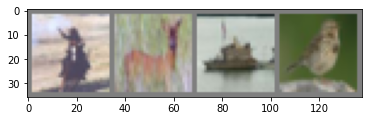

horse deer ship bird


In [23]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

### CNN(컨볼루션 신경망) 정의

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 손실함수 및 최적화 프로그램 정의

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 네트워크 훈련

In [26]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" %
                  (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 2.214
[1,  4000] loss: 1.851
[1,  6000] loss: 1.690
[1,  8000] loss: 1.599
[1, 10000] loss: 1.532
[1, 12000] loss: 1.491
[2,  2000] loss: 1.422
[2,  4000] loss: 1.404
[2,  6000] loss: 1.376
[2,  8000] loss: 1.349
[2, 10000] loss: 1.349
[2, 12000] loss: 1.314
Finished Training


In [27]:
# 훈련된 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 네트워크 테스트

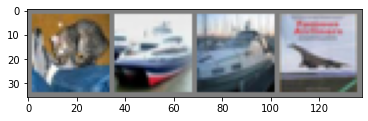

GroundTruth:    cat ship shipplane


In [28]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", ''.join("%5s" % classes[labels[j]] for j in range(4)))

In [29]:
# 저장된 모델을 재로드
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [30]:
outputs = net(images)

In [31]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", ''.join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:   frog  car shipplane


In [32]:
# 네트워크가 전체 datasets에서 어떻게 작동하는지 확인
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print("Accuracy of %5s: %2d %%" % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 56 %
Accuracy of   car: 54 %
Accuracy of  bird: 45 %
Accuracy of   cat: 12 %
Accuracy of  deer: 51 %
Accuracy of   dog: 53 %
Accuracy of  frog: 78 %
Accuracy of horse: 63 %
Accuracy of  ship: 66 %
Accuracy of truck: 67 %


### Training on GPU

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [35]:
# device가 cuda일 경우에만 수행
net.to(device)

# 모든 단계에서 inputs과 targets을 GPU로 보내야함
inputs, labels = data[0].to(device), data[1].to(device)